In [1]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt 
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]
        
    

In [2]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [3]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=220
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))


CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0


5341


Text(0, 0.5, 'Temperature (C)')

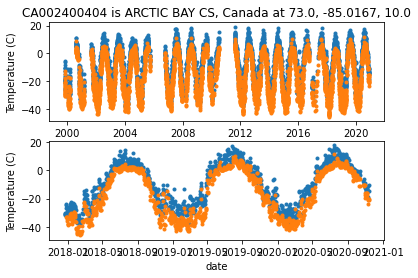

In [4]:
tmaxArray=ghn.getVar(statDict,'TMAX')
days, tmax = zip(*tmaxArray)
tminArray=ghn.getVar(statDict,'TMIN')
days2, tmin = zip(*tminArray)
print(len(days))
fig, ax = plt.subplots(2,1)
ax[0].plot(days,tmax,'.')
ax[0].plot(days2,tmin,'.')
ax[0].set_xlabel("date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[whichStat]))
ax[1].plot(days[-1000:],tmax[-1000:],'.')
ax[1].plot(days2[-1000:],tmin[-1000:],'.')
ax[1].set_xlabel("date")
ax[1].set_ylabel("Temperature (C)")

In [5]:
def getFileName(stationNumber):
    fileName = statNames[stationNumber]+'.dly'
    urlName  ='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

    # Copy a network object to a local file
    urllib.request.urlretrieve(urlName,fileName)
    statDict=ghn.processFile(fileName)
    return statDict

def extractStatDict(statDict=getFileName(220)):
    tMax = ghn.getVar(statDict,'TMAX')
    tMin = ghn.getVar(statDict,'TMAX')
    prcp = ghn.getVar(statDict,'PRCP')
    snow = ghn.getVar(statDict,'SNOW')
    snwd = ghn.getVar(statDict,'SNWD')
    return tMax, tMin, prcp, snow, snwd

def plotData(data, name="TMAX", units="(C)"):
    date, data_y = zip(*data)
    plt.figure()
    plt.plot(date, data_y,'.')
    plt.xlabel("date")
    plt.ylabel("{} ({})".format(name, units))
    return(np.shape(data))

In [6]:
tMax, tMin, prcp, snow, snwd = extractStatDict(getFileName(220))

(5341, 2)

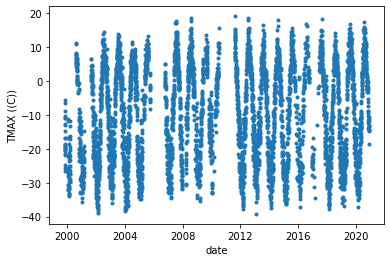

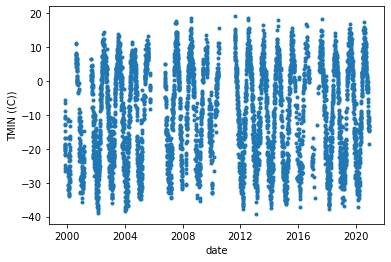

In [7]:
plotData(tMax, "TMAX", "(C)")
plotData(tMin, "TMIN", "(C)")

(500, 2)

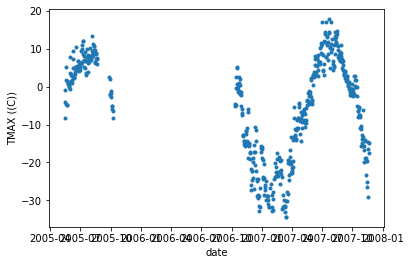

In [8]:
plotData(tMax[1500: 2000], "TMAX", "(C)")

### Handle TMAX

In [11]:
month_df = pd.DataFrame()
for i in range(30):
    month_df[i] = df["tMax"].shift(30-i)
month_df["label"] = df["tMax"].shift(0)
month_df["Date"] = df["Date"]

In [12]:
month_df[25:].head(10)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,label,Date
25,NaN,NaN,NaN,NaN,NaN,-18.6,-20.5,-20.3,-24.8,-19.8,...,-21.6,-18.9,-18.9,-25.7,-26.6,-19.4,-16.8,-19.4,-11.9,2000-02-01
26,NaN,NaN,NaN,NaN,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,...,-18.9,-18.9,-25.7,-26.6,-19.4,-16.8,-19.4,-11.9,-11.3,2000-02-02
27,NaN,NaN,NaN,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,...,-18.9,-25.7,-26.6,-19.4,-16.8,-19.4,-11.9,-11.3,-16.7,2000-02-03
28,NaN,NaN,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,...,-25.7,-26.6,-19.4,-16.8,-19.4,-11.9,-11.3,-16.7,-22.1,2000-02-04
29,NaN,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,...,-26.6,-19.4,-16.8,-19.4,-11.9,-11.3,-16.7,-22.1,-25.8,2000-02-05
30,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,...,-19.4,-16.8,-19.4,-11.9,-11.3,-16.7,-22.1,-25.8,-25.9,2000-02-06
31,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,-8.7,...,-16.8,-19.4,-11.9,-11.3,-16.7,-22.1,-25.8,-25.9,-25.9,2000-02-07
32,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,-8.7,-10.8,...,-19.4,-11.9,-11.3,-16.7,-22.1,-25.8,-25.9,-25.9,-30.8,2000-02-08
33,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,-8.7,-10.8,-12.8,...,-11.9,-11.3,-16.7,-22.1,-25.8,-25.9,-25.9,-30.8,-32.0,2000-02-09
34,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,-8.7,-10.8,-12.8,-10.8,...,-11.3,-16.7,-22.1,-25.8,-25.9,-25.9,-30.8,-32.0,-31.9,2000-02-10


In [13]:
week_df = pd.DataFrame()
for i in range(7):
    week_df[i] = df["tMax"].shift(7-i)
week_df["label"] = df["tMax"].shift(0)
week_df["Date"] = df["Date"]

In [14]:
week_df.head(10)

,0,1,2,3,4,5,6,label,Date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-18.6,1999-11-06
1,NaN,NaN,NaN,NaN,NaN,NaN,-18.6,-20.5,1999-11-07
2,NaN,NaN,NaN,NaN,NaN,-18.6,-20.5,-20.3,1999-11-08
3,NaN,NaN,NaN,NaN,-18.6,-20.5,-20.3,-24.8,1999-11-09
4,NaN,NaN,NaN,-18.6,-20.5,-20.3,-24.8,-19.8,1999-11-10
5,NaN,NaN,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,1999-11-11
6,NaN,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,1999-11-12
7,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,1999-11-13
8,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,1999-11-14
9,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,1999-11-15


In [15]:
month_df.dropna(axis=0, inplace=True)

In [16]:
month_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,label,Date
30,-18.6,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,...,-19.4,-16.8,-19.4,-11.9,-11.3,-16.7,-22.1,-25.8,-25.9,2000-02-06
31,-20.5,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,-8.7,...,-16.8,-19.4,-11.9,-11.3,-16.7,-22.1,-25.8,-25.9,-25.9,2000-02-07
32,-20.3,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,-8.7,-10.8,...,-19.4,-11.9,-11.3,-16.7,-22.1,-25.8,-25.9,-25.9,-30.8,2000-02-08
33,-24.8,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,-8.7,-10.8,-12.8,...,-11.9,-11.3,-16.7,-22.1,-25.8,-25.9,-25.9,-30.8,-32.0,2000-02-09
34,-19.8,-6.6,-5.6,-10.4,-14.7,-21.8,-8.7,-10.8,-12.8,-10.8,...,-11.3,-16.7,-22.1,-25.8,-25.9,-25.9,-30.8,-32.0,-31.9,2000-02-10


In [17]:
month_df.shape

(5311, 32)